In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import xarray as xr
from sqlalchemy.sql import text

plt.style.use("ggplot")

# 1000 Lakes deposition series (NILU BLR grid)

See e-mail from Øyvind received 08.06.2023 at 14.57.

## 1. Runoff normal from NVE (1991-2020)

This has not changed since the preliminary version I processed in November 2022 (see `check_prelim_final_nve_runoff_1991-2020.ipynb` for details). The processing in `1000_lakes_mean_runoff.ipynb` is therefore still valid, as is the dataset `1000_lakes_catchment_mean_runoff_1991-2020.csv`.

## 2. NILU deposition data

From Øyvind:

> - 5-års midler 1978-2021 på BLR-rutenett (0.25°×0.125°): 
> - total non-sea salt sulfur dep (mg S/m2y)
> - total oxidised nitrogen dep (mg N/m2y)
> - total reduced nitrogen dep (mg N/m2y)
> - Periodene 1983-87 og 1988-92 mangler oppsplitting av tot-N i Oks-N/Red-N på BLR-rutenett. Oks-N/Red-N fra 50km x 50km datasettet overføres derfor til BLR datasettet for disse periodene

**Note:** After some exploration, the EMEP 50 x 50 km dataset is quite different to the NILU data. Instead of using the EMEP values, Øyvind has therefore suggested the following:

 * For 1983-87, first perform regression of Oks vs. total N for 1978-82 to obtain the typical proportion of Oks:Red, then use this factor with the totals for 1983-87
 * For 1988-92, do the same, but use regression based on data for 1992-96

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis()

Connection successful.


In [3]:
# Series to use
series_dict = {
    1: ("blr", 1978, 1982),
    29: ("blr", 1983, 1987),  # Assumes 50:50 split between Oks and Red N
    30: ("blr", 1988, 1992),  # Assumes 50:50 split between Oks and Red N
    2: ("blr", 1992, 1996),
    3: ("blr", 1997, 2001),
    4: ("blr", 2002, 2006),
    25: ("blr", 2007, 2011),
    26: ("blr", 2012, 2016),
    66: ("blr", 2017, 2021),
}

In [4]:
# Get outflows and catchments for 1000 lakes
stn_gdf, cat_gdf = nivapy.da.select_jhub_project_catchments([4], eng)

# Reproject to UTM Zone 33N for accurate distances
stn_gdf = stn_gdf.to_crs("epsg:25833")

# Loop over series
df_list = []
for series_id, series_data in series_dict.items():
    grid, st_yr, end_yr = series_data

    # Get spatial grid
    sql = text(f"SELECT * FROM deposition.dep_grid_{grid}")
    grid_gdf = gpd.read_postgis(sql, eng).to_crs("epsg:25833")

    # Read dep data
    sql = (
        "SELECT a.series_id, "
        "  a.cell_id, "
        "  b.name, "
        "  a.value, "
        "  b.unit "
        f"FROM deposition.dep_values_{grid}_grid a, "
        "  deposition.dep_param_defs b "
        "WHERE a.series_id = :series_id "
        "AND a.param_id IN (1, 2, 4) "
        "AND a.param_id = b.param_id"
    )
    if grid == "emep":
        sql += " AND veg_class_id = 1"
    sql = text(sql)
    dep_df = pd.read_sql(sql, eng, params={"series_id": series_id})
    dep_df["par_unit"] = dep_df["name"] + "_" + dep_df["unit"]
    del dep_df["name"], dep_df["unit"], dep_df["series_id"]
    dep_df.set_index(["cell_id", "par_unit"], inplace=True)
    dep_df = dep_df.unstack("par_unit")
    dep_df.columns = dep_df.columns.get_level_values(1)
    dep_df.reset_index(inplace=True)
    dep_df.rename(
        {
            "N(oks)_mg N/m2/year": "n_oks_mgpm2pyr",
            "N(red)_mg N/m2/year": "n_red_mgpm2pyr",
            "S*_mg S/m2/year": "s*_mgpm2pyr",
        },
        inplace=True,
        axis="columns",
    )
    dep_df.index.name = ""

    # Join to BLR grid
    dep_gdf = grid_gdf.merge(dep_df, how="inner", on="cell_id").copy()
    dep_gdf.dropna(how="any", inplace=True)

    # Spatial join. Using 'within' fails for 7 stations that are slightly outside the
    # BLR grid. Using 'sjoin_nearest' patches with the closest values
    # join_gdf = stn_gdf.sjoin(dep_gdf, how="left", predicate="within")
    join_gdf = stn_gdf.sjoin_nearest(dep_gdf, how="left")

    # Tidy
    join_gdf["period"] = f"{st_yr}-{end_yr}"
    join_gdf["grid"] = grid
    join_gdf["n_tot_mgpm2pyr"] = join_gdf["n_oks_mgpm2pyr"] + join_gdf["n_red_mgpm2pyr"]
    cols = [
        "station_id",
        "station_code",
        "station_name",
        "aquamonitor_id",
        "longitude",
        "latitude",
        # "grid",
        # "cell_id",
        "period",
        "n_oks_mgpm2pyr",
        "n_red_mgpm2pyr",
        "n_tot_mgpm2pyr",
        "s*_mgpm2pyr",
    ]
    join_df = join_gdf[cols]
    df_list.append(join_df)

df = pd.concat(df_list, axis="rows")
df.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,period,n_oks_mgpm2pyr,n_red_mgpm2pyr,n_tot_mgpm2pyr,s*_mgpm2pyr
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,1978-1982,414.23,389.37,803.60,782.41
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,1978-1982,576.11,502.89,1079.00,1085.72
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,1978-1982,469.13,412.21,881.34,910.22
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,1978-1982,312.24,281.38,593.62,616.06
4,263,425-2-2,Kottern,26074,12.511994,60.587319,1978-1982,394.63,355.97,750.60,781.49


This dataframe contains all the required data, but it currently assumes a 50:50 split between Oks and Red N for 1983-87 and 1988-92. Øyvind would like to improve these estimated using linear regression for the period before and after the ones with missing values.

In [5]:
# Map periods with data to periods to be patched
period_dict = {"1978-1982": "1983-1987", "1992-1996": "1988-1992"}
for ref_per, update_per in period_dict.items():
    # Perform regression
    print(
        "\n########################################################################################"
    )
    reg_df = df.query("period == @ref_per").copy()
    res = smf.ols(formula="n_oks_mgpm2pyr ~ n_tot_mgpm2pyr - 1", data=reg_df).fit()
    slope = res.params[0]
    print(f"{ref_per}: Slope={slope:.2f}    R2={res.rsquared:.3f}.")
    print(res.summary())

    # Update values
    df["n_oks_mgpm2pyr"] = np.where(
        df["period"] == update_per, slope * df["n_tot_mgpm2pyr"], df["n_oks_mgpm2pyr"]
    )

# Recalculate reduced fraction
df["n_red_mgpm2pyr"] = df["n_tot_mgpm2pyr"] - df["n_oks_mgpm2pyr"]

# Save
csv_path = r"../data/1000_lakes_nilu_dep_1978-2021.csv"
df.to_csv(csv_path, index=False)

df.head()


########################################################################################
1978-1982: Slope=0.49    R2=0.995.
                                 OLS Regression Results                                
Dep. Variable:         n_oks_mgpm2pyr   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          2.117e+05
Date:                Tue, 29 Aug 2023   Prob (F-statistic):                        0.00
Time:                        12:44:46   Log-Likelihood:                         -4680.4
No. Observations:                1001   AIC:                                      9363.
Df Residuals:                    1000   BIC:                                      9368.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                              

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,period,n_oks_mgpm2pyr,n_red_mgpm2pyr,n_tot_mgpm2pyr,s*_mgpm2pyr
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,1978-1982,414.23,389.37,803.60,782.41
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,1978-1982,576.11,502.89,1079.00,1085.72
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,1978-1982,469.13,412.21,881.34,910.22
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,1978-1982,312.24,281.38,593.62,616.06
4,263,425-2-2,Kottern,26074,12.511994,60.587319,1978-1982,394.63,355.97,750.60,781.49


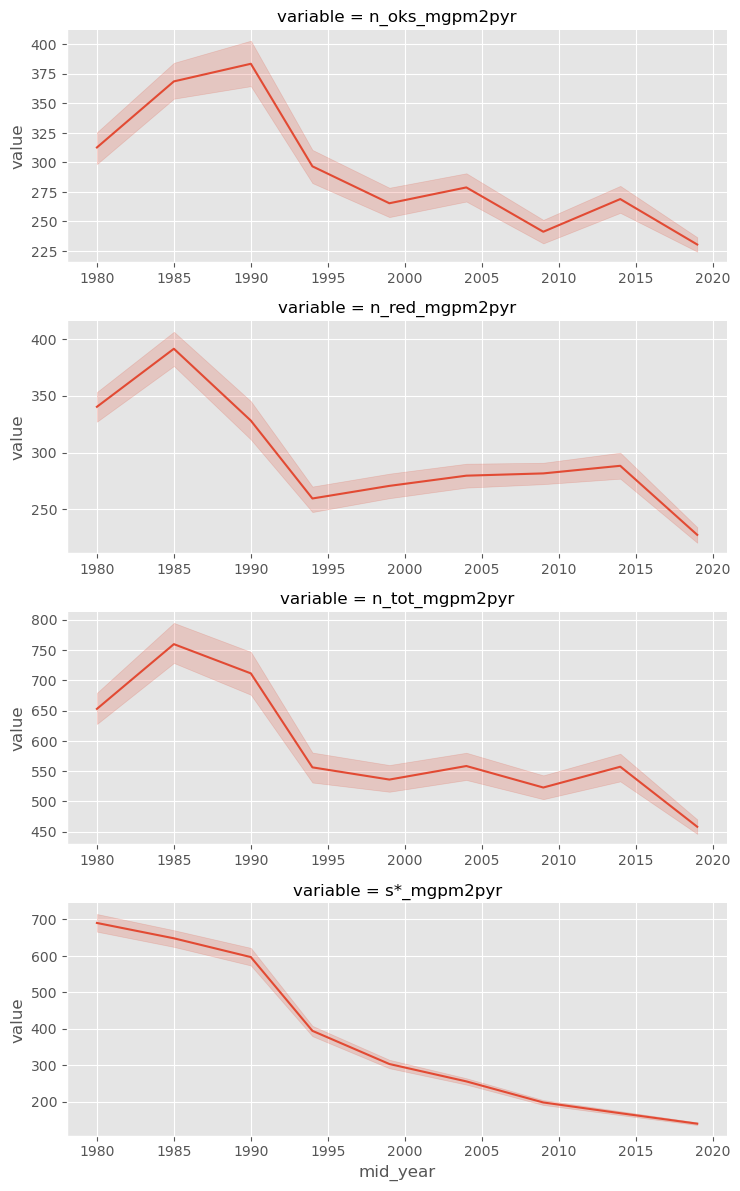

In [6]:
# Plot
df2 = df[
    ["period", "n_oks_mgpm2pyr", "n_red_mgpm2pyr", "n_tot_mgpm2pyr", "s*_mgpm2pyr"]
].melt(id_vars="period")
df2["mid_year"] = (
    df2["period"].str[:4].astype(int) + df2["period"].str[-4:].astype(int)
) / 2
sn.relplot(
    data=df2,
    x="mid_year",
    y="value",
    row="variable",
    kind="line",
    height=3,
    aspect=2.5,
    facet_kws={"sharey": False, "sharex": False},
)

## 3. EMEP deposition scenarios

### 3.1. EMEP historic data for 2017 to 2020

Data for 2021 are not available from the EMEP website, so I'll use the average from 2017-2020 and compare this to 2017-2021 in the NILU data.

**Updated 29.08.2023:** We have decided not to use the EMEP data for 2017-2020, as it is not compatible with the future scenarios. See e-mail from Kari received 29.08.2023 at 11.18 for details.

In [7]:
def calculate_dep_totals(ds):
    """Takes an xarray netCDF dataset in the format used by EMEP and calculates
    grid average deposition totals:

        Total SOx = Wet SOx + Dry SOx
        Total OxN = Wet OxN + Dry OxN
        Total RedN = Wet RedN + Dry RedN
        Total N = Total OxN + Total RedN

    Args:
        ds: xarray dataset

    Returns:
        New variables are added to 'ds'.
    """
    # Pars of interest
    par_list = [
        "DDEP_SOX_m2Grid",
        "WDEP_SOX",
        "DDEP_OXN_m2Grid",
        "WDEP_OXN",
        "DDEP_RDN_m2Grid",
        "WDEP_RDN",
    ]

    # Check N units are consistent
    for par in par_list:
        unit = ds[par].attrs["units"]
        assert unit in ["mgS/m2", "mgN/m2"], "Units not consistent."

    # Calculate total oxidised S
    ds["DEP_SOX"] = ds["WDEP_SOX"] + ds["DDEP_SOX_m2Grid"]
    ds["DEP_SOX"].attrs["units"] = "mgS/m2"

    # Calculate total oxidised N
    ds["DEP_OXN"] = ds["WDEP_OXN"] + ds["DDEP_OXN_m2Grid"]
    ds["DEP_OXN"].attrs["units"] = "mgN/m2"

    # Calculate total reduced N
    ds["DEP_RDN"] = ds["WDEP_RDN"] + ds["DDEP_RDN_m2Grid"]
    ds["DEP_RDN"].attrs["units"] = "mgN/m2"

    # Calculate total N
    ds["DEP_TOTN"] = (
        ds["WDEP_OXN"] + ds["WDEP_RDN"] + ds["DDEP_OXN_m2Grid"] + ds["DDEP_RDN_m2Grid"]
    )
    ds["DEP_TOTN"].attrs["units"] = "mgN/m2"

    return ds

In [8]:
# # List files to process
# file_paths = [
#     f"https://thredds.met.no/thredds/dodsC/data/EMEP/2022_Reporting/EMEP01_rv4.45_year.{year}met_{year}emis_rep2022.nc"
#     for year in range(2017, 2020)
# ]

# # Data for 2020 have a different naming convention/url
# file_paths += [
#     r"https://thredds.met.no/thredds/dodsC/data/EMEP/2022_Reporting/EMEP01_rv4.45_year.2020met_2020emis.nc"
# ]

In [9]:
# # Open datasets
# ds = xr.open_mfdataset(
#     file_paths,
#     combine="by_coords",
# )
# ds

In [10]:
# # Load data from URL into memory to improve performance later
# ds = ds.load()

In [11]:
# # Sum vars in EMEP netCDFs
# ds = calculate_dep_totals(ds)

# # Get time series for points
# par_list = ["DEP_SOX", "DEP_OXN", "DEP_RDN"]
# stn_df = stn_gdf.drop("geom", axis="columns")
# stn_ds = stn_df.set_index("station_id").to_xarray()
# emep_df = (
#     ds[par_list]
#     .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
#     .to_dataframe()
#     .reset_index()
# )
# emep_df["year"] = emep_df["time"].dt.year
# emep_df = emep_df[["station_id", "year"] + par_list]
# emep_df.rename(
#     {
#         "DEP_OXN": "n_oks_mgpm2pyr",
#         "DEP_RDN": "n_red_mgpm2pyr",
#         "DEP_SOX": "s*_mgpm2pyr",
#     },
#     inplace=True,
#     axis="columns",
# )

# # Average 2017 - 2020
# emep_df = emep_df.groupby("station_id").mean().reset_index()

# emep_df.head()

### 3.2. Future scenarios

For the future scenarios, we will use change factors derived by comparing EMEP data for 2030 and 2050 to the EMEP data for 2015 (all supplied as part of the GP review). These factors will then be applied to the NILU data for 2012-16 to estimate future deposition.

In [12]:
scenario = "Baseline"  # 'Baseline', 'MFR' or 'Diet_low'
par_dict = {
    "DEP_OXN": "n_oks_mgpm2pyr",
    "DEP_RDN": "n_red_mgpm2pyr",
    "DEP_SOX": "s*_mgpm2pyr",
}

In [13]:
# Process EMEP scenarios
stn_df = stn_gdf.drop("geom", axis="columns")
stn_ds = stn_df.set_index("station_id").to_xarray()

df_list = []
for year in [2015, 2030, 2050]:
    fpath = f"/home/jovyan/shared/common/icp_waters/deposition_data/gp_review_scenarios/EMEP01_rv4.45_met2015_emis{year}_{scenario}_v1C_CCE-ICPwaters.nc"
    ds = xr.open_dataset(fpath)
    ds = calculate_dep_totals(ds)
    scen_df = (
        ds[par_dict.keys()]
        .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
        .to_dataframe()
        .reset_index()
    )
    scen_df["year"] = year
    scen_df = scen_df[["station_id", "year"] + list(par_dict.keys())]
    scen_df.rename(
        par_dict,
        inplace=True,
        axis="columns",
    )
    df_list.append(scen_df.set_index(["station_id", "year"]))

scen_df = pd.concat(df_list, axis="rows").reset_index()

scen_df.head()

,station_id,year,n_oks_mgpm2pyr,n_red_mgpm2pyr,s*_mgpm2pyr
0,259,2015,314.280640,201.196014,126.080643
1,260,2015,387.043701,275.045197,153.377365
2,261,2015,279.951904,182.708801,106.325272
3,262,2015,280.417969,185.981003,102.197937
4,263,2015,222.135056,135.805481,82.842018


In [14]:
# Calculate change factors and apply to NILU 2012-16
nilu_base_period = "2012-2016"
# nilu_base_period = "2017-2021"
nilu_df = df.query("period == @nilu_base_period").copy()
base_df = scen_df.query("year == 2015").copy()
del base_df["year"]
df_list = []
for year in [2030, 2050]:
    fut_df = scen_df.query("year == @year").copy()
    del fut_df["year"]

    fac_df = pd.merge(
        base_df, fut_df, how="left", on="station_id", suffixes=["_base", "_fut"]
    )
    fac_df = pd.merge(
        fac_df,
        nilu_df[["station_id"] + list(par_dict.values())],
        how="left",
        on="station_id",
    )

    for par in par_dict.values():
        fac_df[par] = fac_df[par] * fac_df[par + "_fut"] / fac_df[par + "_base"]
        del fac_df[par + "_fut"], fac_df[par + "_base"]
    fac_df["n_tot_mgpm2pyr"] = fac_df["n_oks_mgpm2pyr"] + fac_df["n_red_mgpm2pyr"]
    fac_df["period"] = str(year)

    fac_df = pd.merge(
        nilu_df[
            [
                "station_id",
                "station_code",
                "station_name",
                "aquamonitor_id",
                "longitude",
                "latitude",
            ]
        ],
        fac_df,
        how="left",
        on="station_id",
    )
    df_list.append(fac_df)

In [15]:
# Combine historic NILU data with bias-corrected EMEP predictions
df = pd.concat([df] + df_list, axis="rows")

# Save
csv_path = r"../data/1000_lakes_nilu_dep_1978-2021_plus_scenarios.csv"
df.to_csv(csv_path, index=False)

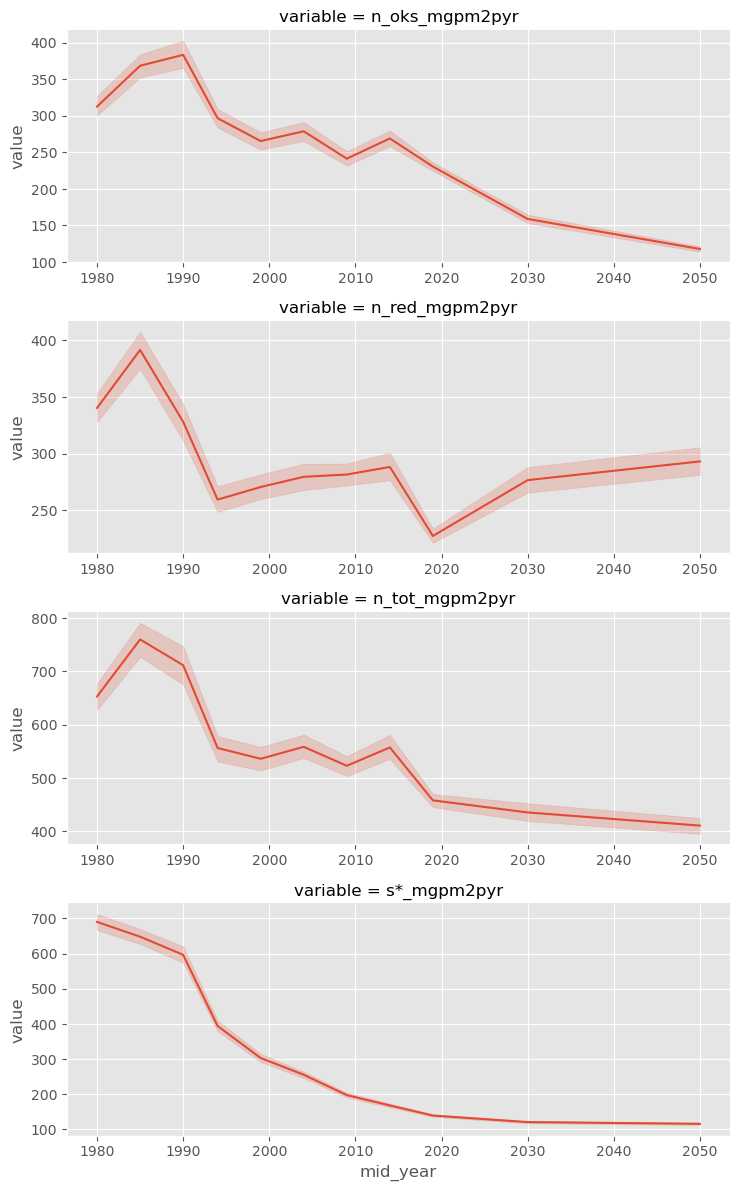

In [16]:
# Plot
df2 = df[
    ["period", "n_oks_mgpm2pyr", "n_red_mgpm2pyr", "n_tot_mgpm2pyr", "s*_mgpm2pyr"]
].melt(id_vars="period")
df2["mid_year"] = (
    df2["period"].str[:4].astype(int) + df2["period"].str[-4:].astype(int)
) / 2
sn.relplot(
    data=df2,
    x="mid_year",
    y="value",
    row="variable",
    kind="line",
    height=3,
    aspect=2.5,
    facet_kws={"sharey": False, "sharex": False},
)

In [17]:
fpath = f"/home/jovyan/shared/common/icp_waters/deposition_data/gp_review_scenarios/EMEP01_rv4.45_met2015_emis2030_Baseline_v1C_CCE-ICPwaters.nc"
ds2030 = xr.open_dataset(fpath)

fpath = f"/home/jovyan/shared/common/icp_waters/deposition_data/gp_review_scenarios/EMEP01_rv4.45_met2015_emis2050_Baseline_v1C_CCE-ICPwaters.nc"
ds2050 = xr.open_dataset(fpath)

In [18]:
print(ds2030["WDEP_RDN"].mean().values, ds2050["WDEP_RDN"].mean().values)
print(ds2030["DDEP_RDN_m2Grid"].mean().values, ds2050["DDEP_RDN_m2Grid"].mean().values)

103.39303 110.945015
49.89674 54.624348
